# Pulsebuilding for QCoDeS

This tutorial covers the offline construction of pulse sequences from idea to numpy array to awg file. No instrument is required. 

## Lingo

Let's settle on a vocabulary. At the highest level, we construct **elements**. These elements will eventually become sequence elements of the AWG 5014 sequencer and can thus consist of different **subelements** corresponding to different channels of the AWG (or several AWGs). Each subelement consists of some number of **segments** (e.g. a ramp, a sine of a certain frequence, a pi-pulse, etc).

There is no reason to maintain a very clear distinction between subelements and elements, since a subelement becomes an element in the case of a single-channel element, and all subelements are in any case independent. For the remainder of this tutorial, we only refer to elements.

## Code abstractions

The pulse building module uses the concept of a **blueprint** which is eventually **forged** into an element. The blueprint is basically a list of segments; this is where the user specifies that "first comes a ramp, then a sine, then another ramp, ...". The forging into an element happens when the user provides the **durations** of the segments. 

## Code implementation

Each segment is either **special** or normal. 

### Normal segments

A normal segment consists of a _unique_ name, a function object, a tuple of arguments to the function, and an optional number of **timesteps**. 

 * The name: can be provided by the user or omitted. If omitted, the segment will get the name of its function. Since all names must be unique, the blueprint _appends numbers_ to names if they occur more than once. The numbers are appended chronologically throughout the blueprint. See example below.
 
 * The function: must be a python function taking at least one argument; the segment duration. If the function takes other arguments (such as ramp slope, frequency, etc.) the duration argument must be the last positional argument. Keyword arguments are currently not allowed.
 
 * The arguments: are in a tuple of $n-1$ arguments for a function taking $n$ arguments, i.e. specifying everything but the duration.
 
 * The number of timesteps: can be 1 (default) or more. This is needed if a segment on one channel is to last while several different segments are run through on another channel of the same element. See example below.


### Special segments

A special segment has a (protected) name and a number of arguments. So far, two special segments are implemented.
 
 * `waituntil`, args [time (int)]:  When put in a blueprint, this function ensures that the _next_ segment starts at the absolute time `time` after the start of the element. It does so by filling any excess time with zeros. It fails if the previous segment will finish after time `time`.
 
 * `makemeanfit`. Not implemented yet.

Let's go!

In [1]:
%matplotlib nbagg
import qcodes.instrument_drivers.tektronix.pulsebuilding as pb

## Basic blueprinting

In [2]:
# The pulsebuilding module comes with a (small) collection of functions appropriate for being segments.
ramp = pb.PulseAtoms.ramp  # args: slope
sine = pb.PulseAtoms.sine  # args: freq, ampl, off

# make a blueprint

# The blueprint takes three (the fourth optional) lists as input
bp1 = pb.BluePrint([ramp, sine, ramp],  # functions
                   [(-1,), (5, 1, 1), (2,)],  # arguments
                   ['', 'wiggle', ''],  # names
                   [1, 2, 1])  # (optional) timesteps

# The blueprint can be inspected
bp1.showPrint()

Segment 1: ramp, <function PulseAtoms.ramp at 0x110db2598>, (-1,), 1
Segment 2: wiggle, <function PulseAtoms.sine at 0x110db2510>, (5, 1, 1), 2
Segment 3: ramp2, <function PulseAtoms.ramp at 0x110db2598>, (2,), 1


In [3]:
# Alternatively, one construct a blueprint by adding segments one-by-one
bp2 = pb.BluePrint([], [], [])
bp2.insertSegment(-1, ramp, (-1,))
bp2.insertSegment(-1, sine, (25, 1, 1), 'wiggle', 2)
bp2.insertSegment(-1, ramp, (2,))

# This achieves the same as the code above, as we may conclude by inspection...
bp2.showPrint()
# ... or by direct comparison
print('---')
print(bp1==bp2)

Segment 1: ramp, <function PulseAtoms.ramp at 0x110db2598>, (-1,), 1
Segment 2: wiggle, <function PulseAtoms.sine at 0x110db2510>, (25, 1, 1), 2
Segment 3: ramp2, <function PulseAtoms.ramp at 0x110db2598>, (2,), 1
---
False


In [4]:
# It is also possible to copy blueprints
bp3 = bp1.copy()
print('Are bp2 and bp3 the same?', bp3==bp1)

# Let's say we now want to modify bp3 to have no sine function but only ramps
bp3.removeSegment('wiggle')  # remove the offending segment
bp3.insertSegment(1, ramp, 1)  # insert a ramp before element 1 (the second element)
bp3.insertSegment(2, ramp, 0)  # insert a ramp

# And let's say that we want to change the frequency of the sine of bp2
# we can adress the argument by its position...
bp2.changeArg('wiggle', 0, 2.5)
# ...or by its name (even though it's NOT a keyword argument)
bp2.changeArg('wiggle', 'freq', 2.5)

Are bp2 and bp3 the same? True


In [5]:
# It can be useful to add two blueprints together
bp4 = pb.BluePrint([ramp], [(1,)], [''])
bp5 = bp4.copy()
for ii in range(3):
    bp4.showPrint()
    print('--')
    bp4 += bp5

Segment 1: ramp, <function PulseAtoms.ramp at 0x110db2598>, (1,), 1
--
Segment 1: ramp, <function PulseAtoms.ramp at 0x110db2598>, (1,), 1
Segment 2: ramp2, <function PulseAtoms.ramp at 0x110db2598>, (1,), 1
--
Segment 1: ramp, <function PulseAtoms.ramp at 0x110db2598>, (1,), 1
Segment 2: ramp2, <function PulseAtoms.ramp at 0x110db2598>, (1,), 1
Segment 3: ramp3, <function PulseAtoms.ramp at 0x110db2598>, (1,), 1
--


## Forging and plotting

<IPython.core.display.Javascript object>


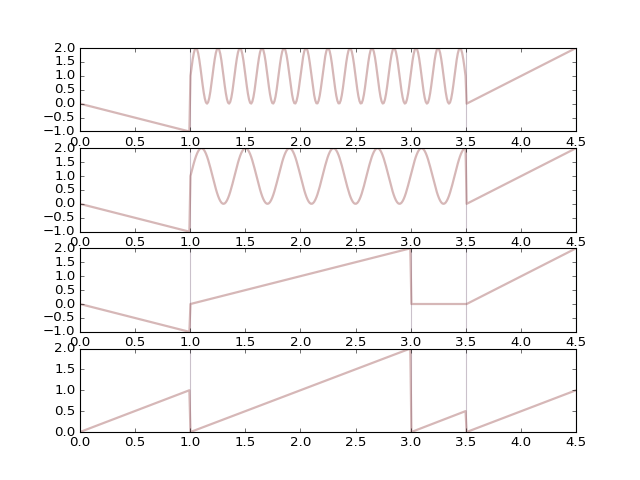

In [6]:
# Finally, we may provide durations and plot and forge the segments
durations = [1, 2, 0.5, 1]

# plot, see that everything we did above makes sense
pb.bluePrintPlotter([bp1, bp2, bp3, bp4], durations)

In [7]:
# forge (not very useful at the moment, but here for completeness)
elem1, newdurs = pb.elementBuilder(bp1, durations)

print(type(elem1))

<class 'numpy.ndarray'>


## More advanced examples

### Multiple argument replacement

<IPython.core.display.Javascript object>


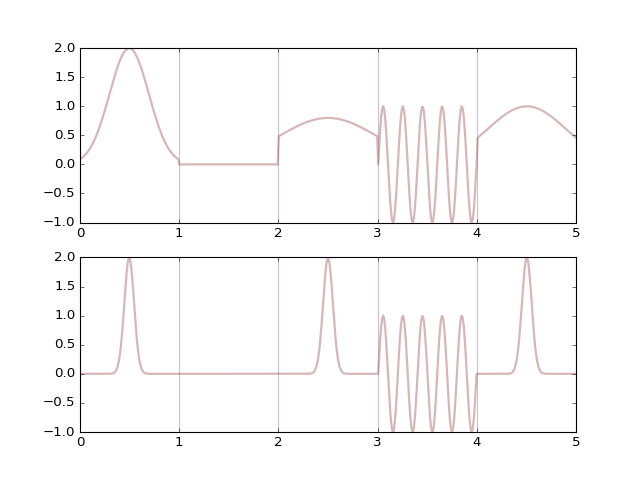

In [18]:
gaussian = pb.PulseAtoms.gaussian

# we make a blueprint with some gaussians
gbp = pb.BluePrint([gaussian, ramp, gaussian, sine, gaussian],
                   [(1, 0.2, 0.5, 0), (0,), (1, 0.5, 0.5, 0), (5, 1, 0), (1, 0.4, 0.5, 0)],
                   ['', '', '', '', ''])

# and realise that all sigmas where way too large...
# Make the gaussians thinner and smaller
gbp2 = gbp.copy()
gbp2.changeArg('gaussian', 'sigma', 0.05, replaceeverywhere=True)
gbp2.changeArg('gaussian', 'ampl', 0.25, replaceeverywhere=True)
pb.bluePrintPlotter([gbp, gbp2], [1, 1, 1, 1, 1])

<IPython.core.display.Javascript object>


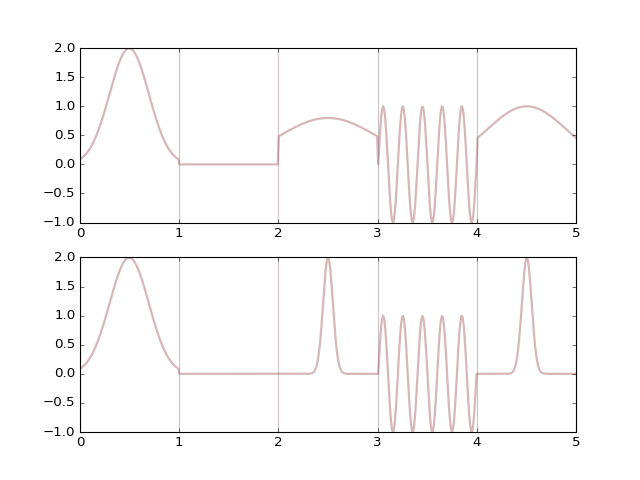

In [22]:
# The 'replaceeverywhere' looks for similar names, so naming can be used to discriminate 

# we make a blueprint with some gaussians
gbp = pb.BluePrint([gaussian, ramp, gaussian, sine, gaussian],
                   [(1, 0.2, 0.5, 0), (0,), (1, 0.5, 0.5, 0), (5, 1, 0), (1, 0.4, 0.5, 0)],
                   ['basgauss', '', 'goodgauss', '', 'goodgauss'])

# and realise that all sigmas where way too large...
# Make the gaussians thinner and smaller
gbp2 = gbp.copy()
gbp2.changeArg('goodgauss', 'sigma', 0.05, replaceeverywhere=True)
gbp2.changeArg('goodgauss', 'ampl', 0.25, replaceeverywhere=True)
pb.bluePrintPlotter([gbp, gbp2], [1, 1, 1, 1, 1])

### Using the 'waituntil' special function

<IPython.core.display.Javascript object>


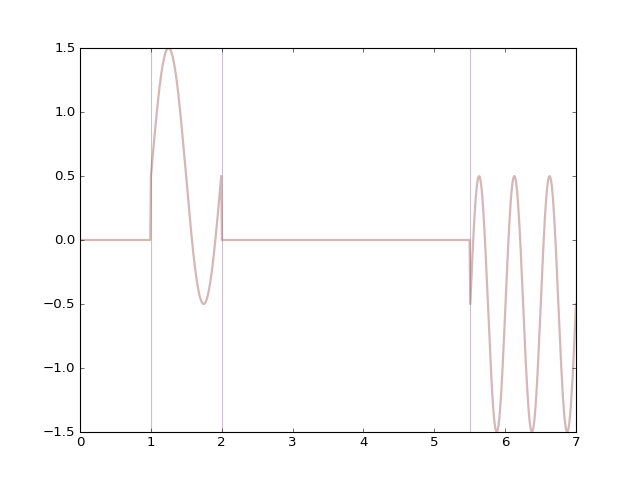

/Users/william/QCoDeS/qcodes/instrument_drivers/tektronix/pulsebuilding.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return list(np.zeros(dur*SR))


In [21]:
# The 'waituntil' function is utilised by adding the string 'waituntil' as a function. The corresponding argument
# is the ABSOLUTE time at which the NEXT segment should begin

bpwait = pb.BluePrint([ramp, sine, 'waituntil', sine],
                      [(0,), (1, 1, 0.5), (5.5,), (2, 1, -0.5)],
                      ['', '', '', ''])

# When plotting/forging, no duration should be specified for the 'waituntil' segment
pb.bluePrintPlotter(bpwait, [1, 1, 1.5])                                